Running bandit 1/2000
Running bandit 101/2000
Running bandit 201/2000
Running bandit 301/2000
Running bandit 401/2000
Running bandit 501/2000
Running bandit 601/2000
Running bandit 701/2000
Running bandit 801/2000
Running bandit 901/2000
Running bandit 1001/2000
Running bandit 1101/2000
Running bandit 1201/2000
Running bandit 1301/2000
Running bandit 1401/2000
Running bandit 1501/2000
Running bandit 1601/2000
Running bandit 1701/2000
Running bandit 1801/2000
Running bandit 1901/2000


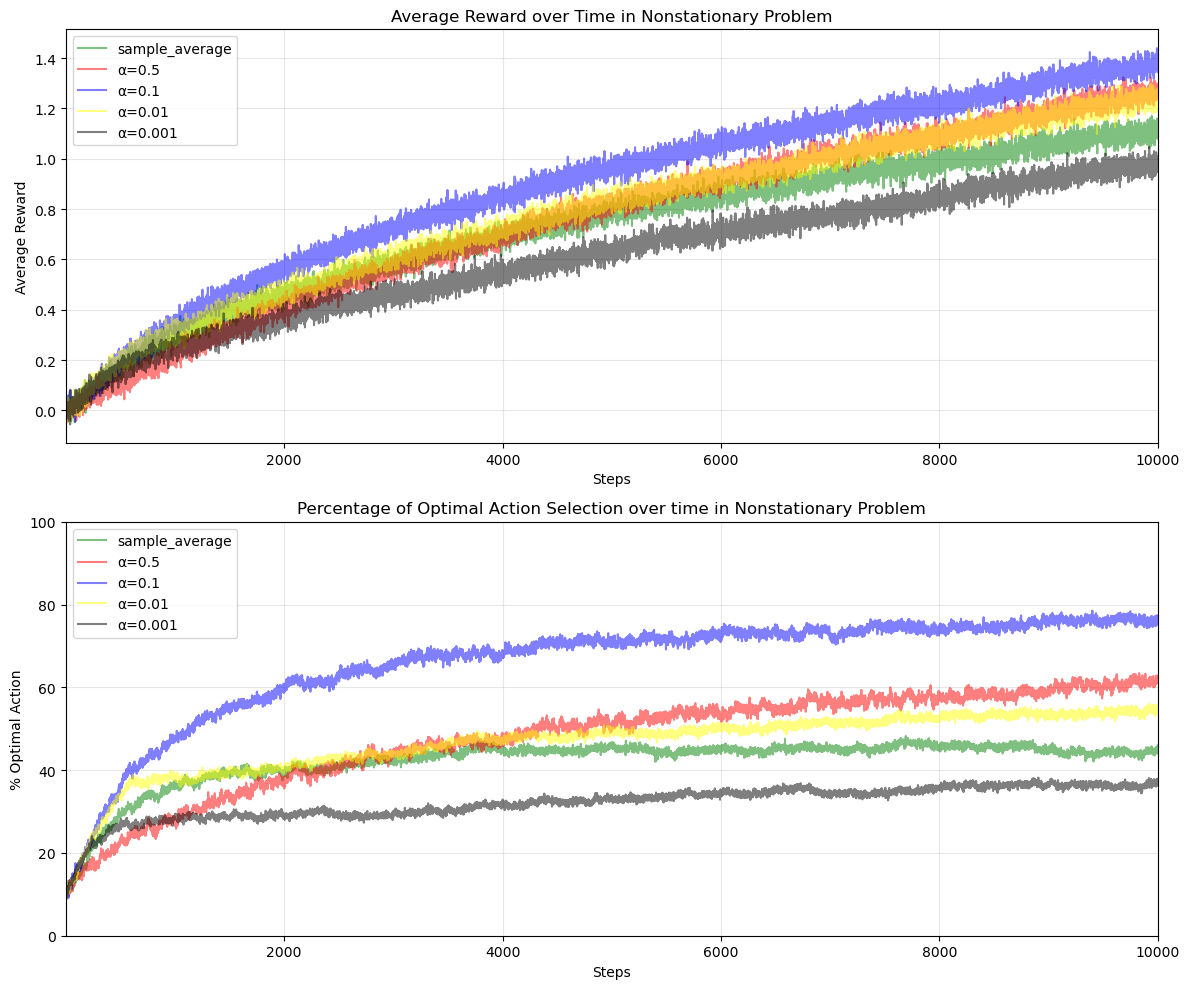

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class NonstationaryBandit:
    
    def __init__(self, n_arms: int = 10, random_walk_std: float = 0.01):
        
        self.n_arms = n_arms
        self.random_walk_std = random_walk_std
        self.q_star = np.zeros(n_arms)
        self.optimal_action = np.argmax(self.q_star)
    
    def step(self) -> int:
        increments = np.random.normal(0, self.random_walk_std, self.n_arms)
        self.q_star += increments
        self.optimal_action = np.argmax(self.q_star)
        return self.optimal_action
    
    def pull(self, action: int) -> float:
        #return self.q_star[action]
        return np.random.normal(self.q_star[action], 1.0)


class EpsilonGreedyAgent:
    
    def __init__(self, n_arms: int = 10, epsilon: float = 0.1, 
                 alpha: float = None, use_sample_average: bool = True,
                 use_sq: bool = False):

        self.n_arms = n_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.use_sample_average = use_sample_average
        self.use_sq = use_sq

        self.Q = np.zeros(n_arms) 
        self.N = np.zeros(n_arms) 
    
    def select_action(self) -> int:
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            max_value = np.max(self.Q)
            max_actions = np.where(self.Q == max_value)[0]
            return np.random.choice(max_actions)
    
    def update(self, action: int, reward: float,steps:int):

        if self.use_sample_average:
            self.N[action] += 1
            self.Q[action] += (reward - self.Q[action]) / self.N[action]
        else:
            if self.use_sq:
                self.Q[action] += (steps/10000) * (reward - self.Q[action])
            else:
                self.Q[action] += self.alpha * (reward - self.Q[action])


def run_experiment(n_bandits: int = 2000, n_steps: int = 10000, 
                   epsilon: float = 0.1, alpha: float = 0.1,
                   random_walk_std: float = 0.01) -> dict:

    results = {
        'sample_average': {
            'rewards': np.zeros((n_bandits, n_steps)),
            'optimal_actions': np.zeros((n_bandits, n_steps))
        },
        'constant_step': {
            'rewards': np.zeros((n_bandits, n_steps)),
            'optimal_actions': np.zeros((n_bandits, n_steps))
        },
        'constant_step_sq': {
            'rewards': np.zeros((n_bandits, n_steps)),
            'optimal_actions': np.zeros((n_bandits, n_steps))
        },
        'constant_step_sq2': {
            'rewards': np.zeros((n_bandits, n_steps)),
            'optimal_actions': np.zeros((n_bandits, n_steps))
        },
        'constant_step_sq3': {
            'rewards': np.zeros((n_bandits, n_steps)),
            'optimal_actions': np.zeros((n_bandits, n_steps))
        }
        
    }
    
    for bandit_idx in range(n_bandits):
        if bandit_idx % 100 == 0:
            print(f"Running bandit {bandit_idx + 1}/{n_bandits}")

        bandit = NonstationaryBandit(random_walk_std=random_walk_std)
        agent_sample_avg = EpsilonGreedyAgent(epsilon=epsilon, use_sample_average=True)
        agent_constant = EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha, use_sample_average=False)
        agent_constant_sq = EpsilonGreedyAgent(epsilon=epsilon, alpha=0.5, use_sample_average=False)
        agent_constant_sq2 = EpsilonGreedyAgent(epsilon=epsilon, alpha=0.01, use_sample_average=False)
        agent_constant_sq3 = EpsilonGreedyAgent(epsilon=epsilon, alpha=0.001, use_sample_average=False)
        for step in range(n_steps):

            optimal_action = bandit.step()
            
            action_sa = agent_sample_avg.select_action()
            reward_sa = bandit.pull(action_sa)
            agent_sample_avg.update(action_sa, reward_sa,step)
            results['sample_average']['rewards'][bandit_idx, step] = reward_sa
            results['sample_average']['optimal_actions'][bandit_idx, step] = (action_sa == optimal_action)
            
            action_cs = agent_constant.select_action()
            reward_cs = bandit.pull(action_cs)
            agent_constant.update(action_cs, reward_cs,step)
            results['constant_step']['rewards'][bandit_idx, step] = reward_cs
            results['constant_step']['optimal_actions'][bandit_idx, step] = (action_cs == optimal_action)

            action_sq = agent_constant_sq.select_action()
            reward_sq = bandit.pull(action_sq)
            agent_constant_sq.update(action_sq, reward_sq,step)
            results['constant_step_sq']['rewards'][bandit_idx, step] = reward_sq
            results['constant_step_sq']['optimal_actions'][bandit_idx, step] = (action_sq == optimal_action)

            action_sq2 = agent_constant_sq2.select_action()
            reward_sq2 = bandit.pull(action_sq2)
            agent_constant_sq2.update(action_sq2, reward_sq2,step)
            results['constant_step_sq2']['rewards'][bandit_idx, step] = reward_sq2
            results['constant_step_sq2']['optimal_actions'][bandit_idx, step] = (action_sq2 == optimal_action)

            action_sq3 = agent_constant_sq3.select_action()
            reward_sq3 = bandit.pull(action_sq3)
            agent_constant_sq3.update(action_sq3, reward_sq3,step)
            results['constant_step_sq3']['rewards'][bandit_idx, step] = reward_sq3
            results['constant_step_sq3']['optimal_actions'][bandit_idx, step] = (action_sq3 == optimal_action)

    
    for method in results:
        results[method]['avg_rewards'] = np.mean(results[method]['rewards'], axis=0)
        results[method]['avg_optimal_actions'] = np.mean(results[method]['optimal_actions'], axis=0) * 100
    
    return results


def plot_results(results: dict, n_steps: int = 10000):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    steps = np.arange(1, n_steps + 1)
    
    # Plot average rewards
    ax1.plot(steps, results['sample_average']['avg_rewards'], 
             label='sample_average', alpha=0.5, linewidth=1.5,color = "green")
    ax1.plot(steps, results['constant_step_sq']['avg_rewards'], 
             label='α=0.5', alpha=0.5, linewidth=1.5,color = "red")
    ax1.plot(steps, results['constant_step']['avg_rewards'], 
             label='α=0.1', alpha=0.5, linewidth=1.5,color = "blue")
    ax1.plot(steps, results['constant_step_sq2']['avg_rewards'], 
             label='α=0.01', alpha=0.5, linewidth=1.5,color = "yellow")
    ax1.plot(steps, results['constant_step_sq3']['avg_rewards'], 
             label='α=0.001', alpha=0.5, linewidth=1.5,color = "black")
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Average Reward')
    ax1.set_title('Average Reward over Time in Nonstationary Problem')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, n_steps)
    
    # Plot % optimal actions
    ax2.plot(steps, results['sample_average']['avg_optimal_actions'], 
             label='sample_average', alpha=0.5, linewidth=1.5,color = "green")
    ax2.plot(steps, results['constant_step_sq']['avg_optimal_actions'], 
             label='α=0.5', alpha=0.5, linewidth=1.5,color = "red")
    ax2.plot(steps, results['constant_step']['avg_optimal_actions'], 
             label='α=0.1', alpha=0.5, linewidth=1.5,color = "blue")
    ax2.plot(steps, results['constant_step_sq2']['avg_optimal_actions'], 
             label='α=0.01', alpha=0.5, linewidth=1.5,color = "yellow")
    ax2.plot(steps, results['constant_step_sq3']['avg_optimal_actions'], 
             label='α=0.001', alpha=0.5, linewidth=1.5,color = "black")
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('% Optimal Action')
    ax2.set_title('Percentage of Optimal Action Selection over time in Nonstationary Problem')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, n_steps)
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    plt.show()
    
    return fig



if __name__ == "__main__":
    
    results = run_experiment(
        n_bandits=2000,
        n_steps=10000,
        epsilon=0.1,
        alpha=0.1,
        random_walk_std=0.01
    )
    
    fig = plot_results(results, n_steps=10000)
    